# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of Python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

## Trading Strategy Using Classification: SVM

The key steps involved in creating the strategy are:
1. Read data
2. Create indicators
3. Calculate returns
4. Train and test data
5. Create output signals
6. Find the best parameters
7. Create the support vector machine
8. Predict the signals
9. Analyse the performance
10. Plot the results

### Import libraries

We will import the necessary libraries for the strategy. These machine learning modules imported from the sklearn library are discussed in more detail in the technical references document in section 1 of this course.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Technical indicator library
import talib as ta

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Read data

The 1-minute OHLCV data for the ICICI bank futures required for backtesting is saved in a CSV file. We have used two days data from 22nd of Feb 2018 to 23rd of Feb 2018.

To read a CSV file, you can use `pandas.read_csv()`.

Syntax: 
```python
import pandas as pd
pd.read_csv(filename)
```
filename: Name of the file in the string format.

You can download this data from the last unit of this course '**Python Codes and Data**'.

In [2]:
# Read the data
Df = pd.read_csv('../data_modules/ICICI Minute Data.csv')
Df.head()

,Time,Open,High,Low,Close,Volume
0,22-02-2018 09:15:59,319.25,319.40,316.05,317.70,143354
1,22-02-2018 09:16:59,317.70,318.20,317.70,318.00,52695
2,22-02-2018 09:17:59,318.00,318.85,318.00,318.55,47179
3,22-02-2018 09:18:59,318.65,319.40,318.50,319.20,44745
4,22-02-2018 09:19:59,319.30,319.85,319.20,319.65,57892


Drop all rows which have no traded volume. This is needed to avoid training on low liquidity moves. Alternatively, you can drop all those rows where volume is less than some value of your choice.

In [3]:
# Drop the rows with zero volume traded
Df = Df.drop(Df[Df['Volume'] == 0].index)

Now, change the `Time` column to a `datetime` format. This is done so that you can check for the market closing time later in the code and square off any open positions before the market closes.

In [4]:
# Convert the 'Time' column into pandas datetime format
Df['Time'] = pd.to_datetime(Df['Time'])

# Set the Time column as index
Df.set_index('Time', inplace=True)

## Create indicators

Next, you decide the time period for which you need to calculate the indicators. For this, you chose a variable `n` with a value of 10 (minutes). This is something you can change as per your choice.

You will be creating all the indicators for the same time period. 

In [5]:
# Create a variable n with a value of 10
n = 10

Next, you will create RSI and some other indicators. These indicators have been discussed in more detail in the technical references document in section 1 of this course.

### Calculate RSI
The RSI calculation contains two parts. 
1. First, the `Close` prices column is shifted down by a single time interval, one minute, in this case.
2. Secondly, `timeperiod` is chosen as `n`, which you have defined earlier as `10` minutes. 

So if you are calculating RSI for 't' minute, you will use Closing prices of 't-10', 't-9', …'t-1' minutes. 

In [6]:
# Create a column by name, RSI and assign the calculation of RSI to it
Df['RSI'] = ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n)

### Calculate SMA and correlation coefficient

Simple Moving Average is calculated using the `rolling` method of pandas with a window of `n` minutes.

The correlation coefficient is calculated between the `Close` prices and Simple Moving Average with a window of `n` minutes.

In [7]:
# Create a column by name, SMA and assign the SMA calculation to it
Df['SMA'] = Df['Close'].shift(1).rolling(window=n).mean()

# Create a column by name, Corr and assign the calculation of correlation to it
Df['Corr'] = Df['Close'].shift(1).rolling(window=n).corr(Df['SMA'].shift(1))

### Calculate SAR and ADX

SAR and ADX are calculated on `High` and `Low` prices because they are intended to be sensitive to new Highs and Lows created. In the SAR indicator, the values of `0.2` represent the acceleration and maximum step parameters. 

In [8]:
# Create a column by name, SAR and assign the SAR calculation to it
Df['SAR'] = ta.SAR(np.array(Df['High'].shift(1)), np.array(Df['Low'].shift(1)),
                   0.2, 0.2)

# Create a column by name, ADX and assign the ADX calculation to it
Df['ADX'] = ta.ADX(np.array(Df['High'].shift(1)), np.array(Df['Low'].shift(1)),
                   np.array(Df['Open']), timeperiod=n)

### Previous minute's OHLC
We will pass the previous minute's `High`, `Low`, and `Open` prices as input to the algorithm. This will help the algorithm sense the volatility of the past time period.

In [9]:
# Create columns high, low and close with previous minute's OHLC data
Df['Prev_High'] = Df['High'].shift(1)
Df['Prev_Low'] = Df['Low'].shift(1)
Df['Prev_Close'] = Df['Close'].shift(1)

We will also create two more columns as features: the change in `Open` prices between last minute and current minute & the difference between current minute's `Open` and last minute's `Close` prices.

In [10]:
# Create columns 'OO' with the difference between the current minute's open and last minute's open
Df['OO'] = Df['Open']-Df['Open'].shift(1)

# Create columns 'OC' with the difference between the current minute's open and last minute's close
Df['OC'] = Df['Open']-Df['Prev_Close']

## Calculate returns
Next, calculate the returns for every data point. We also save returns of past n minutes in n columns named as return1, return2 and so on. This will help the algorithm to understand the trend of the returns in the last n periods.  

In [11]:
# Create a column 'Fut_Ret' with the calculation of returns
Df['Fut_Ret'] = (Df['Open'].shift(-1)-Df['Open'])/Df['Open']

# Create n columns and assign
for i in range(1, n):
    Df['return%i' % i] = Df['Fut_Ret'].shift(i)

### Trim the data

You need to keep the values of indicator `Corr` between -1 and 1, as the correlation coefficient is always between these values. This is done by changing all values less than -1 to -1, and all values greater than 1 to 1.

This doesn't affect our calculations negatively because the extreme values are realised due to NaN values in the data, which need to be handled before training the algorithm. Then we drop all NaNs from the entire dataframe.

In [12]:
# Change the value of 'Corr' to -1 if it is less than -1
Df.loc[Df['Corr'] < -1, 'Corr'] = -1

# Change the value of 'Corr' to 1 if it is greater than 1
Df.loc[Df['Corr'] > 1, 'Corr'] = 1

# Drop the NaN values
Df = Df.dropna()

## Train and test data

We will be using 80% of the data to train and the rest 20% to test. You will create a split parameter that will divide the dataframe in an 80-20 ratio.

This can be changed as per your choice, but it is advisable to give at least 70% data as train data for good results. 

In [13]:
# Create a variable split that stores 80% of the length of the dataframe
t = .8
split = int(t*len(Df))
split

583

## Create output signals

Next, assign signal values corresponding to returns that were calculated earlier. To do this, you will split the data into three equal parts.

1. Highest returns’ quantile is assigned `Signal` 1 or Buy.
2. Middle quantile is assigned `Signal` 0 or do nothing.
3. Lowest quantile is assigned `Signal` -1 or Sell. 

In [14]:
# Create a column by name, 'Signal' and initialize with 0
Df['Signal'] = 0

# Assign a value of 1 to 'Signal' column for the quantile with the highest returns
Df.loc[Df['Fut_Ret'] > Df['Fut_Ret'][:split].quantile(q=0.66), 'Signal'] = 1

# Assign a value of -1 to 'Signal' column for the quantile with the lowest returns
Df.loc[Df['Fut_Ret'] < Df['Fut_Ret'][:split].quantile(q=0.34), 'Signal'] = -1

It is an intraday strategy that requires squaring off all the positions at the end of the day. To do this, at the closing time, you will assign the `Signal` and `Fut_Ret` columns as 0.

Since you are working with the data from an Indian stock, where the closing time is 1530 hours, you will assign `Signal` and `Fut_Ret` as 0 for times at 1529 hours.

For data from other exchanges, this needs to be changed according to the exchange's close time. If your data has entries after closing time, then the `Signal` and `Fut_Ret` values for such rows need to be changed to '0' as well. 

In [15]:
# Assign a value of 0 to 'Signal' column at 1529 time
Df.loc[(Df.index.hour == 15) & (Df.index.minute == 29), 'Signal'] = 0

# Assign a value of 0 to 'Fut_Ret' column at 1529 time
Df.loc[(Df.index.hour == 15) & (Df.index.minute == 29), 'Fut_Ret'] = 0

One last step and then we will be ready with our data!  

### Creating the features and values

Drop the columns `Close`, `Signal`, `Time`, `High`, `Low`, `Volume`, and `Fut_Ret` since the algorithm will not be trained on these features. Next, we assign `Signal` to `y` which is the output variable that you will predict using test data.   

In [16]:
# Use drop method to drop the columns
X = Df.drop(['Close', 'Signal', 'High',
             'Low', 'Volume', 'Fut_Ret'], axis=1)

# Create a variable which contains all the 'Signal' values
y = Df['Signal']

## Find the best parameters

### Pipeline and functions

As the first step to finding the best hyperparameters among C, Gamma and Kernel, you will first create a pipeline of functions required to run in a specific order on the training data. 

The `steps` contains references to functions applied to the data when called through a pipeline function. In this case, you will scale the data first and then fit it to the SVC function. This is done to avoid the effect of the individual weights of the features.

In [17]:
# Create the 'steps' variable with the pipeline functions
steps = [('scaler', StandardScaler()), ('svc', SVC())]

# Pass the 'steps' to the Pipeline function
pipeline = Pipeline(steps)

### Hyperparameters

The hyperparameters are iterated over to arrive at the best possible combination for the given training data. These test values can be changed as per your choice. Here, you will choose 4 test values for `c` and 3 test values for `g`.  

In [18]:
# Test variables for 'c' and 'g'
c = [10, 100, 1000, 10000]
g = [1e-2, 1e-1, 1e0]

The `rbf` is used as a singular entry in the kernel parameters. But you can go ahead and try other kernel functions, such as linear, poly and sigmoid.

<b>Do remember:</b> A higher number of parameters would result in a greater time for the code to run. 

In [19]:
# Intialise the parameters
parameters = {'svc__C': c,
              'svc__gamma': g,
              'svc__kernel': ['rbf']
              }

Next, you need to create a `RandomizedSearchCV` function with a `TimeSeriesSplit` object with a `n_split` value of `2`. This value can be anything more than or equal to 2. The `TimeSeriesSplit` is used to sequentially split a time series. Then `RandomizedSearchCV` arrives at the scores of different random combinations of the hyperparameters.

These scores would be used to find the best parameters and create a newly optimized support vector classifier. Alternatively, you can use a GridSearch here. 

In [20]:
# Call the RandomizedSearchCV function and pass the parameters
rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=2))

### Training on and fetching the best parameters
             
Next, you need to fit the train data to `rcv` created above to obtain the best hyperparameters. The best parameters can be obtained using the `best_params_` method.

In [21]:
# Call the 'fit' method of rcv and pass the train data to it
rcv.fit(X.iloc[:split], y.iloc[:split])

# Call the 'best_params_' method to obtain the best parameters of C
best_C = rcv.best_params_['svc__C']

# Call the 'best_params_' method to obtain the best parameters of kernel
best_kernel = rcv.best_params_['svc__kernel']

# Call the 'best_params_' method to obtain the best parameters of gamma
best_gamma = rcv.best_params_['svc__gamma']

## Create the Support Vector Machine

### Create the new SVC

In this line of code, we instantiate a new support vector classifier function with the best hyperparameters.

In [22]:
# Create a new SVC classifier
cls = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)

### Train the data

As done previously, for finding the best hyperparameters, you will first scale the data before you fit it to the classifier to train on. To do this, you need to instantiate the `StandardScaler` function.

In [23]:
# Instantiate the StandardScaler
ss1 = StandardScaler()

You will use the scaled training data to train the classifier algorithm.

In [24]:
# Pass the scaled train data to the SVC classifier
cls.fit(ss1.fit_transform(X.iloc[:split]), y.iloc[:split])

SVC(C=10000, gamma=0.01)

Congratulations, your prediction model is ready!

## Predict the signals

Now, you can use the test data to make predictions and save the output in a list called `y_predict`. This list will have the predicted values of signals for the test data.  

In [25]:
# Pass the test data to the predict function and store the values into 'y_predict'
y_predict = cls.predict(ss1.transform(X.iloc[split:]))

# Initiate a column by name, 'Pred_Signal' and assign 0 to it
Df['Pred_Signal'] = 0

### Save the predictions

1. To save predicted y values of test data, we can assign `y_predict` to `Pred_Signal` using the split.
2. To save predicted y values for train data, we make predictions for train data and save it similarly.

In [26]:
# Save the predicted values for the train data
Df.iloc[:split, Df.columns.get_loc('Pred_Signal')] = pd.Series(
    cls.predict(ss1.transform(X.iloc[:split])).tolist())

# Save the predicted values for the test data
Df.iloc[split:, Df.columns.get_loc('Pred_Signal')] = y_predict

Since the algorithm was trained on the train data, its accuracy is expected to be better on this train data than the test data. You can print these two separately to check the accuracies. (TRY ON YOUR OWN!)

## Use the model for trading strategy 

### Trading strategy 
        
Our trading strategy is to buy/sell/do nothing at that period for which the algorithm generates the signal. The strategy assumes that you always get a fill at the open prices. 

In [27]:
# Calculate strategy returns and store them in 'Ret1' column
Df['Ret1'] = Df['Fut_Ret']*Df['Pred_Signal']

## Analyse the performance

Please note that here you are using only the test data to compare the performance of the strategy. You can pass the entire 'Ret1' column and check the performance on both the test and train data if you wish to.

The confusion matrix is a table layout that allows visualisation of the performance of a supervised learning algorithm. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another). [Additional Reading on Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [28]:
# Calculate the confusion matrix
cm = confusion_matrix(y[split:], y_predict)
cm

array([[22, 15,  1],
       [27, 22, 17],
       [15, 10, 17]])

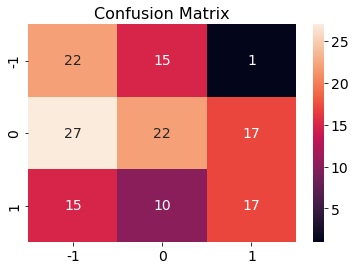

In [29]:
# Set the font sizes
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams.update({'font.size': 14})

# Plot the confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

# Set the axis labels
ax.xaxis.set_ticklabels(['-1', '0', '1'])
ax.yaxis.set_ticklabels(['-1', '0', '1'])
plt.show()

From the confusion matrix, we can see how the model correctly predicted:
* 22/38 instances of class -1
* 22/66 instances of class 0
* 17/42 instances of class 1.

## Classification Report
The classification report computes `precision`, `recall`, `F-measure` and `support` for each class.

The `precision` is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The `recall` is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The `F-beta score` can be interpreted as a weighted harmonic mean of the `precision` and `recall`, where an F-beta score reaches its best value at 1 and the worst score at 0.

The `support` is the number of occurrences of each class in the true prediction.

Reference: [Classification report](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)

In [30]:
# Calculate the classification report
cr = classification_report(y[split:], y_predict)
print(cr)

              precision    recall  f1-score   support

          -1       0.34      0.58      0.43        38
           0       0.47      0.33      0.39        66
           1       0.49      0.40      0.44        42

    accuracy                           0.42       146
   macro avg       0.43      0.44      0.42       146
weighted avg       0.44      0.42      0.42       146



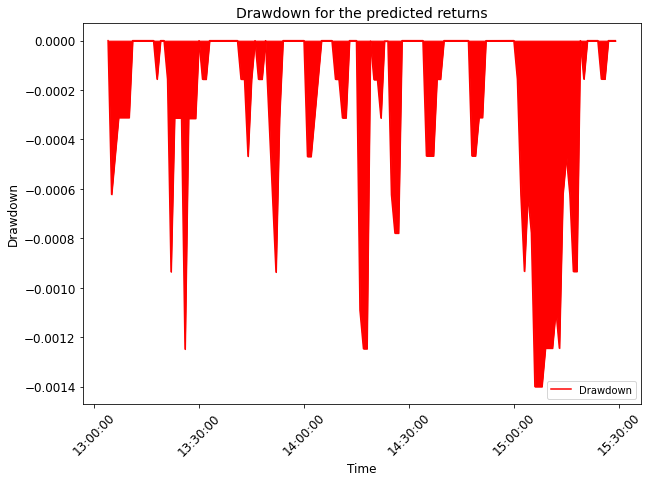

The maximum drawdown is -0.14%


In [31]:
"""
The drawdown metrics and plotting is performed here
"""
# Calculate the cumulative returns
cum_rets = (Df['Ret1'][split:]+1).cumprod()

# Calculate the running maximum
running_max = np.maximum.accumulate(cum_rets.dropna())

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (cum_rets)/running_max - 1
drawdown.index = cum_rets.index

# Calculate the maximum drawdown
max_dd = drawdown.min()*100

# Plot the drawdown
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(drawdown, color='r')
ax.fill_between(drawdown.index, drawdown.values, color='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M:%S"))

# Set the font sizes
_ = plt.xticks(rotation=45)
plt.title('Drawdown for the predicted returns', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Drawdown', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.legend(labels=["Drawdown"], prop={'size': 10}, loc="lower right")

# Display the plot
plt.show()
print("The maximum drawdown is %.2f" % max_dd+"%")

In [32]:
# Calculate the annualised Sharpe ratio
sharpe = np.sqrt(252*6.25*60) * \
    Df['Ret1'][split:].mean() / Df['Ret1'][split:].std()

print("The annualised Sharpe ratio is %.2f" % sharpe)

The annualised Sharpe ratio is 77.74


## Plot the results

Now you can plot the results to visualise the performance.

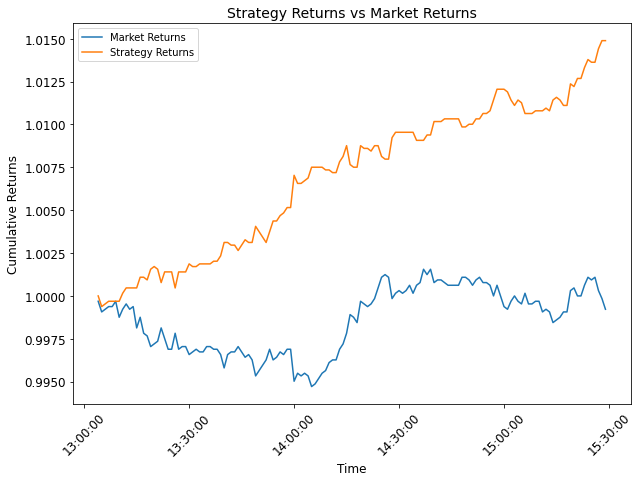

The strategy return is 1.49%


In [33]:
# Plotting the returns
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot((Df['Fut_Ret'][split:]+1).cumprod())
ax.plot((Df['Ret1'][split:]+1).cumprod())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M:%S"))
_ = plt.xticks(rotation=45)

# Setting the labels and font sizes
plt.title('Strategy Returns vs Market Returns', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.legend(labels=["Market Returns", "Strategy Returns"],
          prop={'size': 10}, loc="upper left")
plt.show()


return_strategy = ((Df['Ret1'][split:]+1).cumprod().tail(1)[0]-1)*100
print("The strategy return is %.2f" % return_strategy + "%")

## Now, it's your turn! 

### Tweak the code
 
You can tweak the code in the following ways:
1. Use different data sets: backtest and try out the model on different data sets!
2. Features: create your own features using different indicators that could improve the prediction accuracy
3. Try different CV splits
4. Try Grid Search for best hyperparameters selection. Try different kernels and check for results 
5. Change the trading strategy as you wish! <br><br>